In [1]:
# I used conda with python 3.9

def install_dependencies():
    !pip install -qq fastai
    !pip install -qq --upgrade transformers diffusers ftfy
    !conda install -y -qq ffmpeg

# Uncomment this line if you'd like to install the dependencies. 
#install_dependencies()

In [2]:
import os
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from fastcore.all import concat
from pathlib import Path

from huggingface_hub import notebook_login
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.layer_norm2.weight', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.17.layer_norm2.bias', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.18.layer_norm1.weight', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'visi

In [5]:
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

In [6]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1)
    latent = latent.latent_dist.sample()*vae_magic      
    return latent

def _latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs/2+0.5).clamp(0,1)
    return imgs

def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs/2+0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs*255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

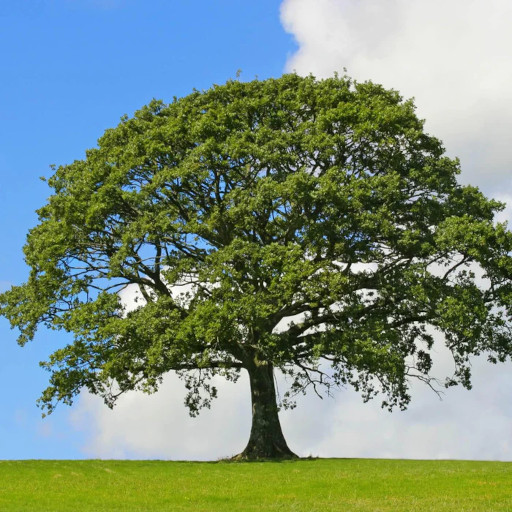

In [20]:
img = Image.open('./images/oak_tree.jpg').resize((512,512));img

In [21]:
encoded = image2latent(img); encoded.shape

torch.Size([1, 4, 64, 64])

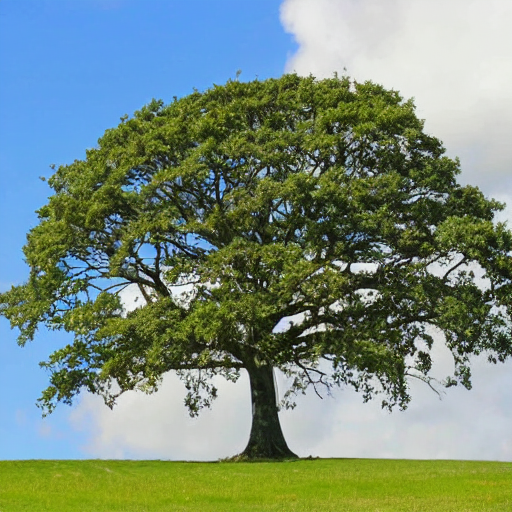

In [22]:
latents2images(encoded)[0]

In [23]:
for i in range(10):
    encoded = image2latent(latents2images(encoded)[0])

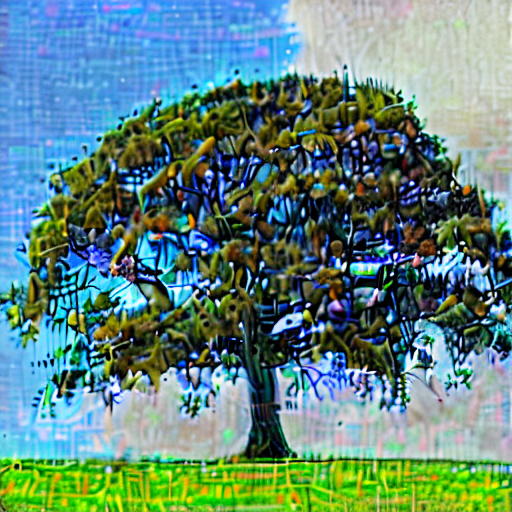

In [24]:
latents2images(encoded)[0]

50% blend against original image

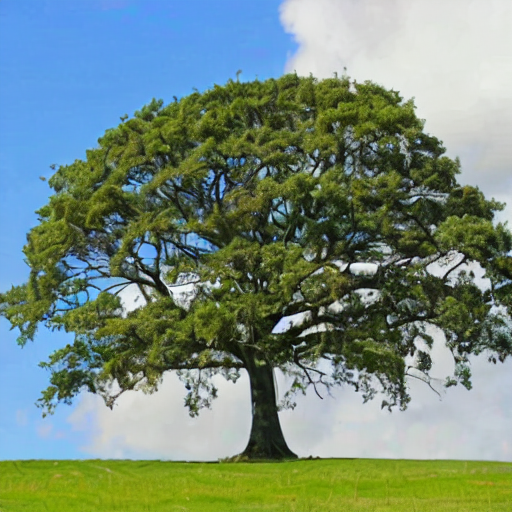

In [26]:
encoded = image2latent(img); encoded.shape

for i in range(100):
    blended_img = Image.blend(img,latents2images(encoded)[0],0.5)
    encoded = image2latent(blended_img)

latents2images(encoded)[0]

50% blend against previous latent round trip

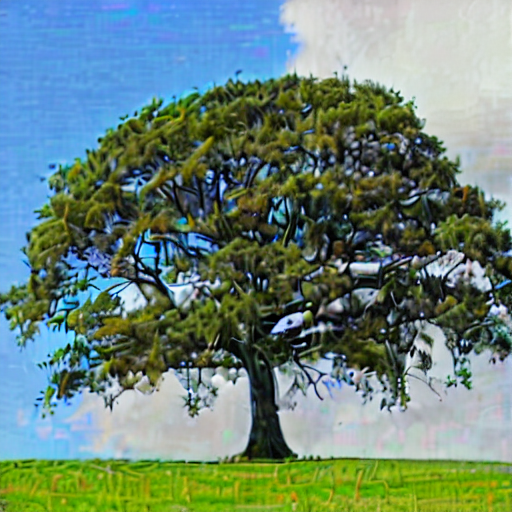

In [27]:
encoded = image2latent(img); encoded.shape

blended_img = img.copy()
for i in range(10):
    blended_img = Image.blend(blended_img,latents2images(encoded)[0],0.5)
    encoded = image2latent(blended_img)

latents2images(encoded)[0]

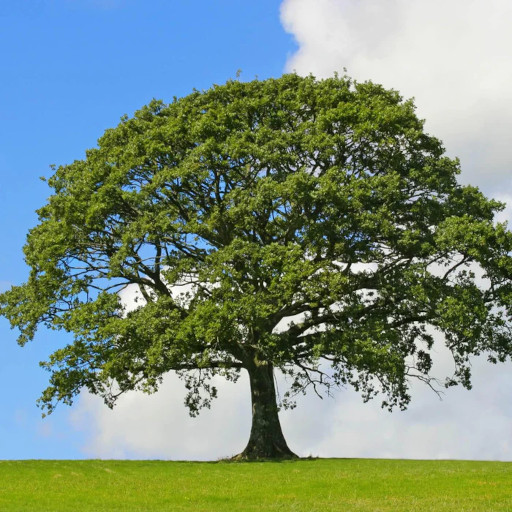

In [29]:
img